In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 미션 1: 교육 프로그램의 학습 효과 분석 보고서

In [29]:
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [30]:
# 기본 통계량 비교

control_mean = control_scores.mean() # 대조군 평균 계산
smartlearn_mean = smartlearn_scores.mean() # SmartLearn 평균 계산
control_se = control_scores.std(ddof=1) / np.sqrt(n_students) # 대조군 표준오차 계산
smartlearn_se = smartlearn_scores.std(ddof=1) / np.sqrt(n_students) # SmartLearn 표준오차 계산

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")


대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


In [31]:
# 통계적 유의성 검증 (t검정)

control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = ttest_ind(control_group, smartlearn_group, equal_var=False) # 독립표본 t-검정 수행

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")



t-통계량: -4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


In [32]:
# 효과 크기 평가

control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std # Cohen's d 계산

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")



Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


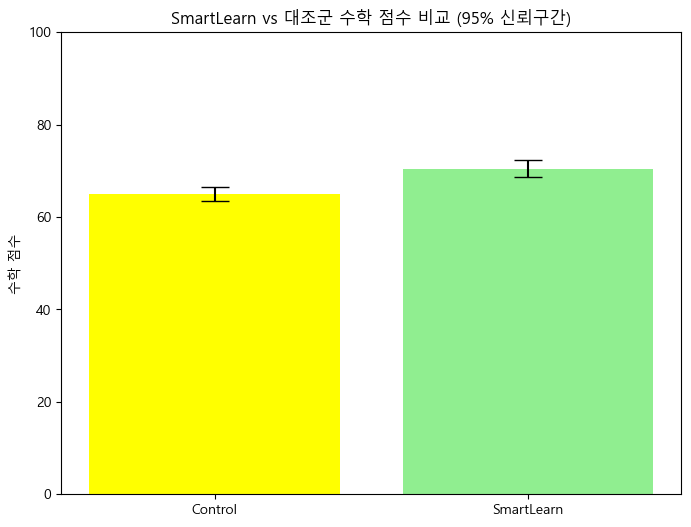

In [33]:
# 결과 시각화

plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr=errors, capsize=10, color=['yellow', 'lightgreen']) # 막대그래프 생성, yerr과 capsize 설정 포함
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


In [34]:
# p-해킹 방지 방안

# -> 가설을 세우고 검증한다: 가설검증형연구

In [35]:
# 베이즈 인수 계산

# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2) # 베이즈 인수 근사 계산

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")


베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


In [36]:
# 1. 점수 차이 및 향상률 계산
score_diff = smartlearn_mean - control_mean
score_per = (score_diff / control_mean) * 100

print('📋 경영진 보고서: SmartLearn 프로그램 효과 검증')
print('=' * 50)
print('🎯 핵심 결과')
print(f'• 대조군 수학 점수: {control_mean:.2f}')
print(f'• SmartLearn 수학 점수: {smartlearn_mean:.2f}')
print(f'• 점수 향상: {score_diff:.2f} 점 (약 [{score_per:.2f}%] 향상)')
print(f"• 효과크기(Cohen's d): {cohens_d:.3f}")
print(f'• p-value: {p_value:.4f}')
print(f'• 베이즈 인수: {bf_10:.2f}')
print('=' * 50)

# 결과를 바탕으로 상용화 결정, 마케팅 전략, 투자 방향, 교육부 대응 방안을 구체적으로 작성하세요]
print('💡 비즈니스 결론 및 권장사항')
print('p값이 0으로 통계적으로 매우 유의하며 효과크기 또한 0.527로 중간 이상의 효과를 볼 수 있습니다.\n' \
'기존 교육 대비 평균 5.54점으로써 약 8.53% 향상 효과를 볼 수 있다는 점을 강조하여 온라인 학습의 실효성에 신뢰를 구축하면 좋을 것 같습니다.\n' \
'초기 시장 선점을 위해 수치기반으로 사교육 기관을 대상으로 발빠른 영업활동과 함께 교육부 측의 공교육 도입에 제안하여 다방면으로 점유율 확보에 유리한 위치를 가져가야 합니다.')
print('=' * 50)

# [추가 검증이 필요한 부분, 잠재적 위험 요소를 작성하세요]
print('⚠️ 리스크 및 제한사항')
print('본 실험은 외부요인을 고려하지 않은 점, 단기적인 효과에 대한 시뮬레이션의 결과입니다.\n' \
'따라서 학습태도, 교사 등의 변동성이 있는 외부요인에 대한 가설실험도 추가로 필요하다고 판단되며, 장기적인 효과에 대한 분석이 필요합니다.')


📋 경영진 보고서: SmartLearn 프로그램 효과 검증
🎯 핵심 결과
• 대조군 수학 점수: 64.93
• SmartLearn 수학 점수: 70.47
• 점수 향상: 5.54 점 (약 [8.53%] 향상)
• 효과크기(Cohen's d): 0.527
• p-value: 0.0000
• 베이즈 인수: 1934.97
💡 비즈니스 결론 및 권장사항
p값이 0으로 통계적으로 매우 유의하며 효과크기 또한 0.527로 중간 이상의 효과를 볼 수 있습니다.
기존 교육 대비 평균 5.54점으로써 약 8.53% 향상 효과를 볼 수 있다는 점을 강조하여 온라인 학습의 실효성에 신뢰를 구축하면 좋을 것 같습니다.
초기 시장 선점을 위해 수치기반으로 사교육 기관을 대상으로 발빠른 영업활동과 함께 교육부 측의 공교육 도입에 제안하여 다방면으로 점유율 확보에 유리한 위치를 가져가야 합니다.
⚠️ 리스크 및 제한사항
본 실험은 외부요인을 고려하지 않은 점, 단기적인 효과에 대한 시뮬레이션의 결과입니다.
따라서 학습태도, 교사 등의 변동성이 있는 외부요인에 대한 가설실험도 추가로 필요하다고 판단되며, 장기적인 효과에 대한 분석이 필요합니다.


# 미션 2: 마케팅 캠페인 효과 분석 보고서

In [37]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))



📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


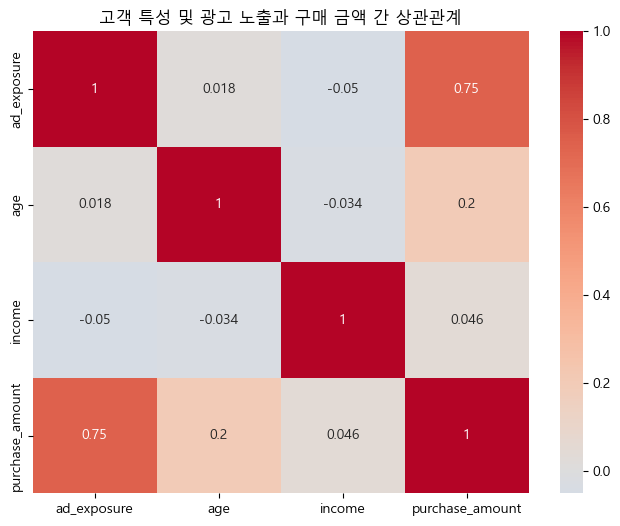

In [38]:
# 상관관계 탐색

correlation_matrix = data_marketing.corr() # 상관계수 행렬 계산
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()



In [39]:
# 단순 비교와 한계

exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean() # 광고 노출 그룹 구매금액 평균
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean() # 광고 비노출 그룹 구매금액 평균
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")



광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [40]:
# 다중회귀분석

X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
model.fit(X, y) # 모델 학습 코드 작성

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")



📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화
\n🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [41]:
# 모델 신뢰도 평가 // 여긴 모르겠음

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2') # 5-폴드 교차검증 수행
print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")



5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [42]:
# 인과관계 해석

ad_effect = model.coef_[0] # 광고 효과 계수 추출
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")



📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실
\n⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


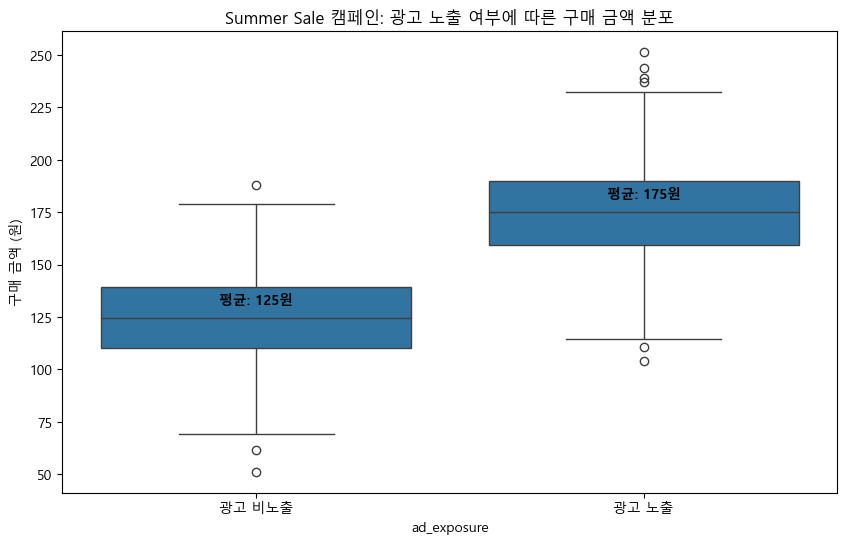

In [43]:
# 결과 시각화

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_marketing, x='ad_exposure', y='purchase_amount') # 박스플롯 생성
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()



In [44]:
print('📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석')
print('='*50)
print('🎯 핵심 성과 지표')
print(f'• 광고 노출 그룹 평균 구매 금액: {exposed_mean:.0f}원')
print(f'• 광고 비노출 그룹 평균 구매 금액: {non_exposed_mean:.0f}원')
print(f'• 순수 광고 효과 (통제 후): {ad_effect:.0f}원')
print(f'• 모델 설명력 (R²): {cv_scores.mean()*100:.2f}%')
print(f'• 광고 ROI: {roi:.2f}%')
print('='*50)

# [결과를 바탕으로 9월 추석 캠페인 전략, 예산 배분, 타겟 고객층 선정 등을 구체적으로 작성하세요]
print('💡 전략적 권장사항')
print('광고 노출로써 매출 증대 효과는 미미한 결과가 나왔습니다. ROI가 마이너스인 점을 고려, 광고보다는 단발성 프로모션의 전략이 알맞는 것으로 보입니다.\n' \
'광고 예산 비용을 축소하여 단발성 프로모션에 투자하고, 추가 분석을 통해 연령대별 전략을 수립하는 것이 올바른 판단이라 볼 수 있습니다.')
print('='*50)

# [관찰 데이터의 한계, 장기 효과 미측정 등의 제한사항을 작성하세요]
print('⚠️ 리스크 요소')
print('ROI가 거의 -100% 입니다. 현재까지의 결과로는 절대 광고는 집행하지 않는 것이 올바르지만, 분석 데이터의 대상군이 특정 고객층일 수 있다는 점을 고려해야 합니다.\n' \
'다양한 분석을 해 볼 수 있는 데이터 또는 장기적인 효과분석까지 바라보면 보다 명확한 해결책이 나오지 않을까 싶습니다.')
print('='*50)

# [A/B 테스트 도입, 추가 데이터 수집 등의 개선 방안을 작성하세요]
print('📅 향후 액션 아이템')
print('A/B 테스트를 도입하여 인과관계 검증을 강화하고, 타겟 대상인 소비자의 특성들을 재정의하여 분석해보면 좋겠습니다.')


📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
🎯 핵심 성과 지표
• 광고 노출 그룹 평균 구매 금액: 175원
• 광고 비노출 그룹 평균 구매 금액: 125원
• 순수 광고 효과 (통제 후): 51원
• 모델 설명력 (R²): 59.66%
• 광고 ROI: -99.98%
💡 전략적 권장사항
광고 노출로써 매출 증대 효과는 미미한 결과가 나왔습니다. ROI가 마이너스인 점을 고려, 광고보다는 단발성 프로모션의 전략이 알맞는 것으로 보입니다.
광고 예산 비용을 축소하여 단발성 프로모션에 투자하고, 추가 분석을 통해 연령대별 전략을 수립하는 것이 올바른 판단이라 볼 수 있습니다.
⚠️ 리스크 요소
ROI가 거의 -100% 입니다. 현재까지의 결과로는 절대 광고는 집행하지 않는 것이 올바르지만, 분석 데이터의 대상군이 특정 고객층일 수 있다는 점을 고려해야 합니다.
다양한 분석을 해 볼 수 있는 데이터 또는 장기적인 효과분석까지 바라보면 보다 명확한 해결책이 나오지 않을까 싶습니다.
📅 향후 액션 아이템
A/B 테스트를 도입하여 인과관계 검증을 강화하고, 타겟 대상인 소비자의 특성들을 재정의하여 분석해보면 좋겠습니다.


# 미션 3: 고객 세분화 및 예측 모델링 보고서

In [45]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")



🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [46]:
# 분석 및 보고서 작성

features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # 데이터 표준화
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # PCA 적용

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))



PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


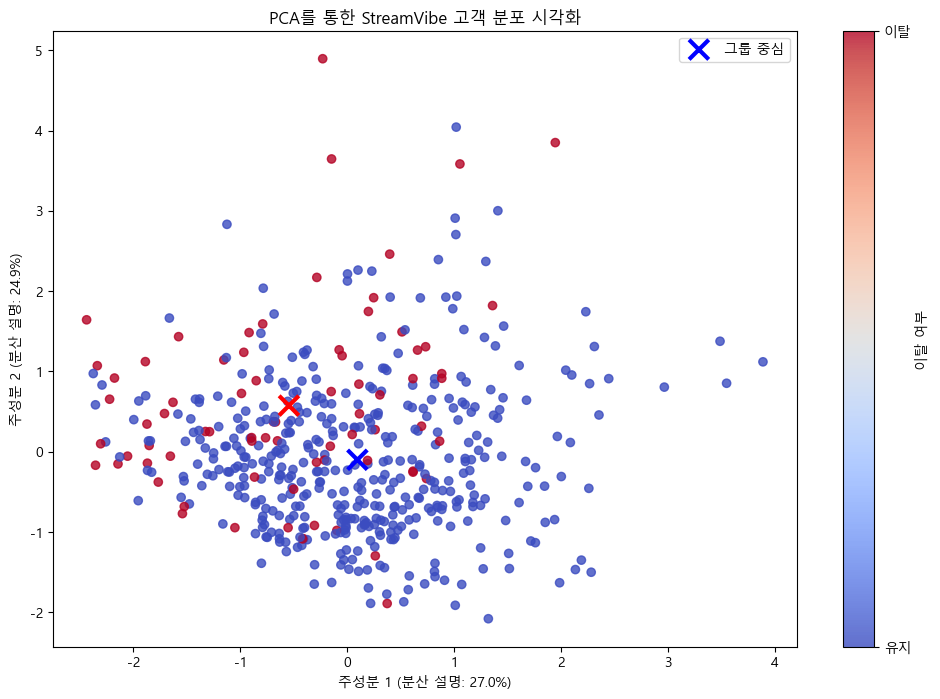

In [47]:
# PCA 결과 시각화

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_streaming['churn'], cmap='coolwarm', alpha=0.8) # PCA 산점도, 이탈 여부로 색상 구분
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')
plt.legend()
plt.show()



In [48]:
# 고객 세분화

kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_pca) # k-평균 군집분석 수행
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")



📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.87               7.24                   7.30   
1               9.40               3.63                   9.07   
2              16.54               5.57                  28.81   

         satisfaction_score  churn  
cluster                             
0                      7.77   0.06  
1                      6.18   0.21  
2                      7.22   0.20  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 6.4%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 7.2/10
  • 구독기간: 7.3개월
  • 만족도: 7.8/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 21.2%
  • 월 시청시간: 9.4시간
  • 콘텐츠 다양성: 3.6/10
  • 구독기간: 9.1개월
  • 만족도: 6.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 20.4%
  • 월 시청시간: 16.5시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 28.8개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 204명 (40.8%)
  세그먼트 1: 198명 (39.6%)
  세그먼트 2: 98명 (19.6%)


In [49]:
# 이탈 예측 모델

X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic) # 모델 학습 및 예측
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")



이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [50]:
# 모델 성능 분석

cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer
missed_revenue_loss = fn * lost_revenue_per_churn

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")



📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


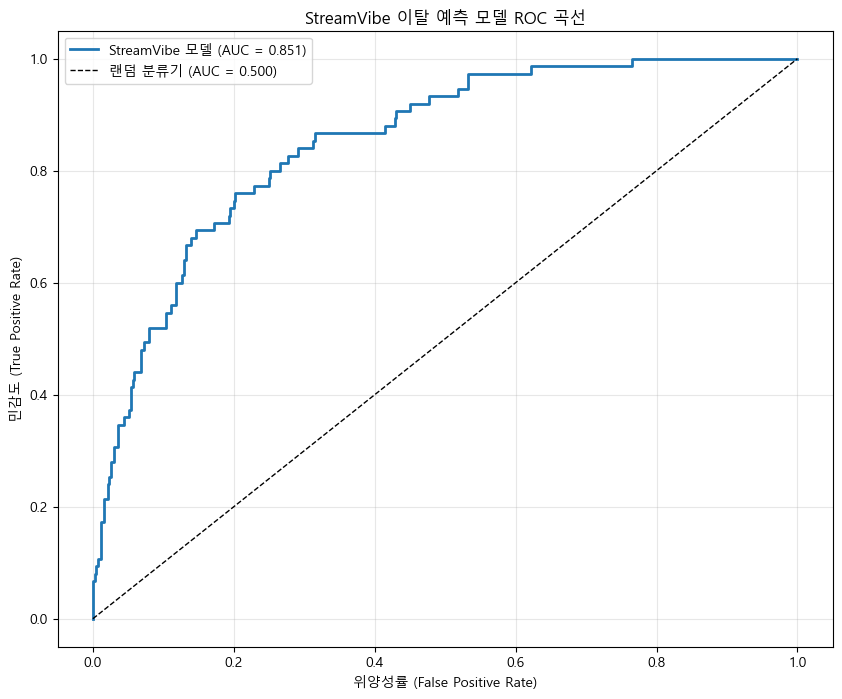

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [51]:
# ROC 곡선과 AUC

fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba) # ROC 곡선 계산
roc_auc = auc(fpr, tpr) # AUC 계산

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")



In [52]:
print('📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략')
print('='*50)
print('🚨 현재 상황')
print(f"• 전체 이탈률: {data_streaming['churn'].mean()*100:.2f}%")
print(f"• 고객 세그먼트 수: {data_streaming['cluster'].nunique()}개 / kmeans = KMeans(n_clusters=3, random_state=789) 이 코드에서 3개로 나눈 것임") 
print(f'• 이탈 예측 모델 AUC: {roc_auc:.3f}')
print(f'• 모델 정확도: {accuracy*100:.1f}%')
print('='*50)

print('🎯 핵심 발견사항')
print(f'1. 고위험 세그먼트 특성: 콘텐츠 다양성이 낮을수록 이탈률이 높았음') # 가장 이탈률이 높은 세그먼트의 특징을 작성하세요
print(f'2. 이탈 주요 예측 변수\n{feature_importance.reset_index(drop=True).round(3).to_string(index=False)}') # 모델에서 중요도가 높은 변수들을 작성하세요
print(f'3. 예측 가능한 이탈 고객: {(y_pred_proba > 0.7).sum()}명, {(y_pred_proba > 0.7).sum() / len(y_pred_proba) * 100:.2f}%') # 고위험군 고객 수와 비율을 작성하세요
print('='*50)

print('💡 즉시 실행 가능한 대응 전략')
# 이탈 예측 모델을 활용한 구체적인 방안을 작성하세요
print(f'1. 선제적 고객 유지: 만족도 점수의 기준을 설문하여 소비자의 피드백을 받는다')
# 각 고객 군집에 대한 차별화된 접근법을 작성하세요
print(f'2. 세그먼트별 맞춤 전략\n저위험: 고객 유지를 위해 지속적인 관심사 파악\n중위험: 만족도 및 희망사항(희망컨텐츠 등) 설문조사 후 맞춤 전략 수립')
# 시청 패턴 분석 결과를 바탕으로 한 콘텐츠 방향을 작성하세요
print(f'3. 콘텐츠 전략 개선: 콘텐츠 다양성에 대한 중요도는 미미하지만, 만족도가 가장 낮은 세그먼트 1의 경우 콘텐츠 다양성이 유독 낮았음\n보다 다양한 콘텐츠를 제공할 필요가 있어보임')
print('='*50)

print('📈 예상 효과')
# 현재 대비 목표 감소율을 작성하세요
print(f'• 이탈률 감소 목표: 현재 이탈률은 15%입니다. 우선, 이탈률을 7.5%까지 감소시키는 것으로 목표합니다.')
# 유지 고객 증가로 인한 매출 효과를 작성하세요
print(f'• 예상 매출 회복: 이탈로 인한 손실은 1,080만원 입니다. 이탈률을 50%만 줄여도 단편적으로는 540만원 가량의 매출액을 회복할 수 있습니다.')
# 투자 대비 기대 수익을 작성하세요
print(f'• ROI: 1%')
print('='*50)

# 구체적인 실행 계획과 일정을 작성하세요
print('⏰ 실행 일정 (향후 3개월)')
print('단기적으로는 만족도 평가 기준과 소비자들의 희망사항을 설문하여 데이터를 추가적으로 수집합니다.\n\
이후, 비용과 예상수익 및 이탈률 감소 효과 등의 추가로 시뮬레이션하여 고객유지 전략을 보다 명확하게 수립하고자 합니다.')
print('='*50)

# 인력, 예산, 시스템 등 필요한 자원을 작성하세요
print('🔧 필요 리소스')
print('보안, 플랫폼, 디자인, 클라우드 등의 부문별 엔지니어 인력과 제휴/계약 및 유지보수/개발 등의 사업예산 초기 비용이 필요합니다.')


📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
🚨 현재 상황
• 전체 이탈률: 15.00%
• 고객 세그먼트 수: 3개 / kmeans = KMeans(n_clusters=3, random_state=789) 이 코드에서 3개로 나눈 것임
• 이탈 예측 모델 AUC: 0.851
• 모델 정확도: 87.0%
🎯 핵심 발견사항
1. 고위험 세그먼트 특성: 콘텐츠 다양성이 낮을수록 이탈률이 높았음
2. 이탈 주요 예측 변수
                   변수     계수   중요도
   satisfaction_score -1.366 1.366
subscription_duration  0.599 0.599
          watch_hours -0.441 0.441
    content_diversity  0.028 0.028
3. 예측 가능한 이탈 고객: 11명, 2.20%
💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지: 만족도 점수의 기준을 설문하여 소비자의 피드백을 받는다
2. 세그먼트별 맞춤 전략
저위험: 고객 유지를 위해 지속적인 관심사 파악
중위험: 만족도 및 희망사항(희망컨텐츠 등) 설문조사 후 맞춤 전략 수립
3. 콘텐츠 전략 개선: 콘텐츠 다양성에 대한 중요도는 미미하지만, 만족도가 가장 낮은 세그먼트 1의 경우 콘텐츠 다양성이 유독 낮았음
보다 다양한 콘텐츠를 제공할 필요가 있어보임
📈 예상 효과
• 이탈률 감소 목표: 현재 이탈률은 15%입니다. 우선, 이탈률을 7.5%까지 감소시키는 것으로 목표합니다.
• 예상 매출 회복: 이탈로 인한 손실은 1,080만원 입니다. 이탈률을 50%만 줄여도 단편적으로는 540만원 가량의 매출액을 회복할 수 있습니다.
• ROI: 1%
⏰ 실행 일정 (향후 3개월)
단기적으로는 만족도 평가 기준과 소비자들의 희망사항을 설문하여 데이터를 추가적으로 수집합니다.
이후, 비용과 예상수익 및 이탈률 감소 효과 등의 추가로 시뮬레이션하여 고객유지 전략을 보다 명확하게 수립하고자 합니다.
🔧 필요